In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import seaborn as sns


In [2]:
#data_url = "https://panamadata.blob.core.windows.net/icij/"
data_url = "../offshore_leaks_csvs-20170104/"

## Look into Addresses table

In [3]:
addresses = pd.read_csv(data_url + "Addresses.csv", dtype={'note':str})
addresses.set_index(['node_id'], inplace=True)
addresses.head()

,address,icij_id,valid_until,country_codes,countries,sourceID,note
node_id,,,,,,,
14000001,-\t27 ROSEWOOD DRIVE #16-19 SINGAPORE 737920,6991059DFFB057DF310B9BF31CC4A0E6,The Panama Papers data is current through 2015,SGP,Singapore,Panama Papers,NaN
14000002,"""Almaly Village"" v.5, Almaty Kazakhstan",C65A269424AA1A8BBAC416FA30150938,The Panama Papers data is current through 2015,KAZ,Kazakhstan,Panama Papers,NaN
14000003,"""Cantonia"" South Road St Georges Hill Weybridg...",240EE44DFB70AF775E6CD02AF8CB889B,The Panama Papers data is current through 2015,GBR,United Kingdom,Panama Papers,NaN
14000004,"""CAY-OS"" NEW ROAD; ST.SAMPSON; GUERNSEY; CHANN...",340C6D3D2FC60AE58C53BB3618129C43,The Panama Papers data is current through 2015,GGY,Guernsey,Panama Papers,NaN
14000005,"""Chirag"" Plot No 652; Mwamba Road; Kizingo; Mo...",6DBCD74F5AAB63EABC166885CE8CD7CD,The Panama Papers data is current through 2015,KEN,Kenya,Panama Papers,NaN


In [4]:
addresses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151605 entries, 14000001 to 28000023
Data columns (total 7 columns):
address          151604 non-null object
icij_id          93982 non-null object
valid_until      151605 non-null object
country_codes    150714 non-null object
countries        150714 non-null object
sourceID         151605 non-null object
note             23 non-null object
dtypes: object(7)
memory usage: 9.3+ MB


#### How may sources are there?

In [5]:
addresses['sourceID'].unique()

array(['Panama Papers', 'Offshore Leaks', 'Bahamas Leaks'], dtype=object)

#### No need to have both 'countries and country_codes columns

In [6]:
addresses = addresses.drop(['countries'], axis=1)

In [7]:
addresses['note'].unique()

array([nan, 'Record manually added from leaked documents'], dtype=object)

#### Convert 'note' field into a binary field indicating whether it's manual entry

In [8]:
addresses['note'] = addresses['note'].fillna("");
addresses['manual_entry'] = [0 if note == "" else 1 for note in addresses['note'] ]
addresses.drop(['note'], axis=1, inplace=True)
addresses.head()

,address,icij_id,valid_until,country_codes,sourceID,manual_entry
node_id,,,,,,
14000001,-\t27 ROSEWOOD DRIVE #16-19 SINGAPORE 737920,6991059DFFB057DF310B9BF31CC4A0E6,The Panama Papers data is current through 2015,SGP,Panama Papers,0
14000002,"""Almaly Village"" v.5, Almaty Kazakhstan",C65A269424AA1A8BBAC416FA30150938,The Panama Papers data is current through 2015,KAZ,Panama Papers,0
14000003,"""Cantonia"" South Road St Georges Hill Weybridg...",240EE44DFB70AF775E6CD02AF8CB889B,The Panama Papers data is current through 2015,GBR,Panama Papers,0
14000004,"""CAY-OS"" NEW ROAD; ST.SAMPSON; GUERNSEY; CHANN...",340C6D3D2FC60AE58C53BB3618129C43,The Panama Papers data is current through 2015,GGY,Panama Papers,0
14000005,"""Chirag"" Plot No 652; Mwamba Road; Kizingo; Mo...",6DBCD74F5AAB63EABC166885CE8CD7CD,The Panama Papers data is current through 2015,KEN,Panama Papers,0


## Now look at the Entities table

In [9]:
entities = pd.read_csv(data_url + "Entities.csv", low_memory=False)
entities.head()

,name,original_name,former_name,jurisdiction,jurisdiction_description,company_type,address,internal_id,incorporation_date,inactivation_date,...,dorm_date,status,service_provider,ibcRUC,country_codes,countries,note,valid_until,node_id,sourceID
0,"TIANSHENG INDUSTRY AND TRADING CO., LTD.","TIANSHENG INDUSTRY AND TRADING CO., LTD.",NaN,SAM,Samoa,NaN,ORION HOUSE SERVICES (HK) LIMITED ROOM 1401; 1...,1001256.0,23-MAR-2006,18-FEB-2013,...,NaN,Defaulted,Mossack Fonseca,25221,HKG,Hong Kong,NaN,The Panama Papers data is current through 2015,10000001,Panama Papers
1,"NINGBO SUNRISE ENTERPRISES UNITED CO., LTD.","NINGBO SUNRISE ENTERPRISES UNITED CO., LTD.",NaN,SAM,Samoa,NaN,ORION HOUSE SERVICES (HK) LIMITED ROOM 1401; 1...,1001263.0,27-MAR-2006,27-FEB-2014,...,NaN,Defaulted,Mossack Fonseca,25249,HKG,Hong Kong,NaN,The Panama Papers data is current through 2015,10000002,Panama Papers
2,"HOTFOCUS CO., LTD.","HOTFOCUS CO., LTD.",NaN,SAM,Samoa,NaN,ORION HOUSE SERVICES (HK) LIMITED ROOM 1401; 1...,1000896.0,10-JAN-2006,15-FEB-2012,...,NaN,Defaulted,Mossack Fonseca,24138,HKG,Hong Kong,NaN,The Panama Papers data is current through 2015,10000003,Panama Papers
3,"SKY-BLUE GIFTS & TOYS CO., LTD.","SKY-BLUE GIFTS & TOYS CO., LTD.",NaN,SAM,Samoa,NaN,ORION HOUSE SERVICES (HK) LIMITED ROOM 1401; 1...,1000914.0,06-JAN-2006,16-FEB-2009,...,NaN,Defaulted,Mossack Fonseca,24012,HKG,Hong Kong,NaN,The Panama Papers data is current through 2015,10000004,Panama Papers
4,FORTUNEMAKER INVESTMENTS CORPORATION,FORTUNEMAKER INVESTMENTS CORPORATION,NaN,SAM,Samoa,NaN,LOYAL PORT LIMITED 8/F; CRAWFORD TOWER 99 JERV...,1001266.0,19-APR-2006,15-MAY-2009,...,NaN,Changed agent,Mossack Fonseca,R25638,HKG,Hong Kong,NaN,The Panama Papers data is current through 2015,10000005,Panama Papers


In [10]:
entities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495038 entries, 0 to 495037
Data columns (total 21 columns):
name                        495034 non-null object
original_name               389522 non-null object
former_name                 6726 non-null object
jurisdiction                495038 non-null object
jurisdiction_description    495038 non-null object
company_type                103227 non-null object
address                     299319 non-null object
internal_id                 389522 non-null float64
incorporation_date          485607 non-null object
inactivation_date           144760 non-null object
struck_off_date             272240 non-null object
dorm_date                   20207 non-null object
status                      310106 non-null object
service_provider            319150 non-null object
ibcRUC                      431263 non-null object
country_codes               318360 non-null object
countries                   318360 non-null object
note                    

### Look at distribution of different features

#### As we can see, most of the features in this dataset are categorical. Let's pick features what we think can be relevant in clustering entities. Use 'incorporation date' and ignore other dates. We can come back to them later. Also we can add two more features indicating the day of the week and month the company is incorporated.

In [11]:
entities.columns

Index(['name', 'original_name', 'former_name', 'jurisdiction',
       'jurisdiction_description', 'company_type', 'address', 'internal_id',
       'incorporation_date', 'inactivation_date', 'struck_off_date',
       'dorm_date', 'status', 'service_provider', 'ibcRUC', 'country_codes',
       'countries', 'note', 'valid_until', 'node_id', 'sourceID'],
      dtype='object')

#### Sources of leaks

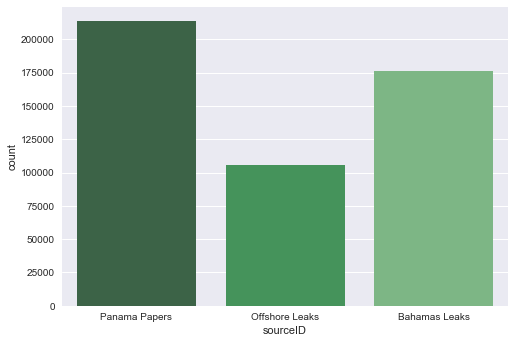

In [12]:
sns.countplot(x='sourceID', data=entities, palette="Greens_d")

#### Company types

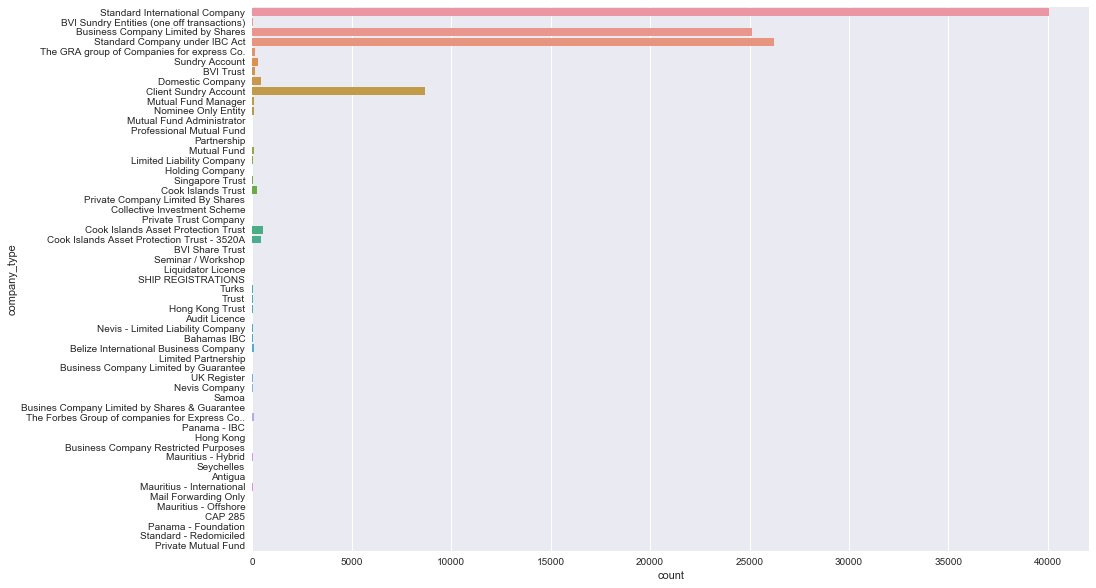

In [13]:
f, ax = plt.subplots(figsize=(15, 10))
sns.countplot(y='company_type', data=entities, ax=ax)

#### Service provider for offshore accounts

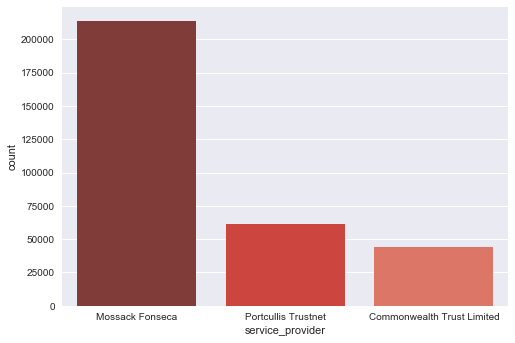

In [14]:
sns.countplot(x='service_provider', data=entities, palette="Reds_d");

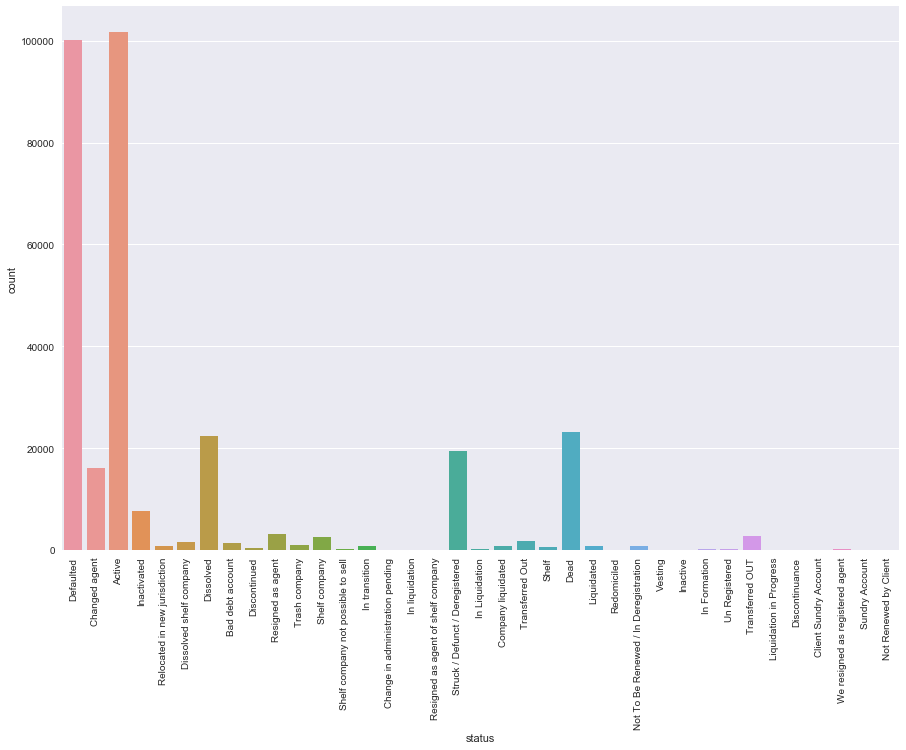

In [15]:
f, ax = plt.subplots(figsize=(15, 10))

#rotateTickLabels(ax, 90, 'x')
g = sns.countplot(x='status', data=entities)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

In [16]:
features = [ 'name','jurisdiction', 'company_type','incorporation_date', 'status', 'service_provider', 'country_codes',
       'note', 'valid_until', 'sourceID']
print(features)

['name', 'jurisdiction', 'company_type', 'incorporation_date', 'status', 'service_provider', 'country_codes', 'note', 'valid_until', 'sourceID']


#### Let's create features for incorporation date and incorporation month based on incorporation date.

In [17]:
entities = entities[features]

entities['incorporation_date'] = pd.to_datetime(entities['incorporation_date'])
entities['incorporation_month'] = entities['incorporation_date'].dt.strftime('%m')
entities['incorporation_dayofweek'] = entities['incorporation_date'].dt.weekday_name

#remove instances where name or incorporation date is not available.
entities.dropna(axis=0, subset=['name', 'incorporation_date'], inplace=True)
entities.head()

,name,jurisdiction,company_type,incorporation_date,status,service_provider,country_codes,note,valid_until,sourceID,incorporation_month,incorporation_dayofweek
0,"TIANSHENG INDUSTRY AND TRADING CO., LTD.",SAM,NaN,2006-03-23,Defaulted,Mossack Fonseca,HKG,NaN,The Panama Papers data is current through 2015,Panama Papers,03,Thursday
1,"NINGBO SUNRISE ENTERPRISES UNITED CO., LTD.",SAM,NaN,2006-03-27,Defaulted,Mossack Fonseca,HKG,NaN,The Panama Papers data is current through 2015,Panama Papers,03,Monday
2,"HOTFOCUS CO., LTD.",SAM,NaN,2006-01-10,Defaulted,Mossack Fonseca,HKG,NaN,The Panama Papers data is current through 2015,Panama Papers,01,Tuesday
3,"SKY-BLUE GIFTS & TOYS CO., LTD.",SAM,NaN,2006-01-06,Defaulted,Mossack Fonseca,HKG,NaN,The Panama Papers data is current through 2015,Panama Papers,01,Friday
4,FORTUNEMAKER INVESTMENTS CORPORATION,SAM,NaN,2006-04-19,Changed agent,Mossack Fonseca,HKG,NaN,The Panama Papers data is current through 2015,Panama Papers,04,Wednesday


In [18]:
X = entities.drop(['name', 'incorporation_date'], axis=1)
X.head()

,jurisdiction,company_type,status,service_provider,country_codes,note,valid_until,sourceID,incorporation_month,incorporation_dayofweek
0,SAM,NaN,Defaulted,Mossack Fonseca,HKG,NaN,The Panama Papers data is current through 2015,Panama Papers,03,Thursday
1,SAM,NaN,Defaulted,Mossack Fonseca,HKG,NaN,The Panama Papers data is current through 2015,Panama Papers,03,Monday
2,SAM,NaN,Defaulted,Mossack Fonseca,HKG,NaN,The Panama Papers data is current through 2015,Panama Papers,01,Tuesday
3,SAM,NaN,Defaulted,Mossack Fonseca,HKG,NaN,The Panama Papers data is current through 2015,Panama Papers,01,Friday
4,SAM,NaN,Changed agent,Mossack Fonseca,HKG,NaN,The Panama Papers data is current through 2015,Panama Papers,04,Wednesday


### Convert these categorical features into numerical features using Label encoding. 

#### create a preprocessor that applies label encoding to multiple categorical columns in a dataframe. The code for this preprocessor is from http://blog.districtdatalabs.com/building-a-classifier-from-census-data


In [19]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder

class EncodeCategorical(BaseEstimator, TransformerMixin):
    """
    Encodes a specified list of columns or all columns if None.
    """

    def __init__(self, columns=None):
        self.columns  = columns
        self.encoders = None

    def fit(self, data, target=None):
        """
        Expects a data frame with named columns to encode.
        """
        # Encode all columns if columns is None
        if self.columns is None:
            self.columns = data.columns

        # Fit a label encoder for each column in the data frame
        self.encoders = {
            column: LabelEncoder().fit(data[column])
            for column in self.columns
        }
        return self

    def transform(self, data):
        """
        Uses the encoders to transform a data frame.
        """
        output = data.copy()
        for column, encoder in self.encoders.items():
            output[column] = encoder.transform(data[column])

        return output
    
    def inverse_transform(self, data):
        """
        Uses the encoders to transform a data frame.
        """
        output = data.copy()
        for column, encoder in self.encoders.items():
            output[column] = encoder.inverse_transform(data[column])

        return output

In [20]:
X[pd.isnull(X)]  = 'NaN'
encoder = EncodeCategorical(X.columns).fit(X)
X_encoded = encoder.transform(X)
X_encoded.head()

,jurisdiction,company_type,status,service_provider,country_codes,note,valid_until,sourceID,incorporation_month,incorporation_dayofweek
0,28,31,7,1,139,4,2,2,2,4
1,28,31,7,1,139,4,2,2,2,1
2,28,31,7,1,139,4,2,2,0,5
3,28,31,7,1,139,4,2,2,0,0
4,28,31,3,1,139,4,2,2,3,6


In [21]:
print("Shape of the input dataset being used for clustering: %s"%str(X_encoded.shape))
print("Shape of the original entities before extracting features and one-hot encoding: %s"%str(entities.shape))

Shape of the input dataset being used for clustering: (485603, 10)
Shape of the original entities before extracting features and one-hot encoding: (485603, 12)


### Let's apply k_modes clustering and use elbow method to find optimal number of clusters

#### Applying K-Means clustering with dataset where all features are categorical doesn't make sense since we can't use eucladian distance to measure means. We can use something like K-Modes clustering which is more suitable for categorical features.

#### https://stackoverflow.com/questions/41827660/reveal-k-modes-cluster-features

In [22]:
from kmodes import kmodes

n_clusters = range(2,10)
costs = []

for n in n_clusters:
    km = kmodes.KModes(n, init='Huang', n_init=5).fit(X_encoded)
    costs.append(km.cost_)
    print(n, km.cost_)


2 1813960.0
3 1456143.0
4 1377015.0
5 1336809.0
6 1305385.0
7 1247976.0
8 1235371.0
9 1152618.0


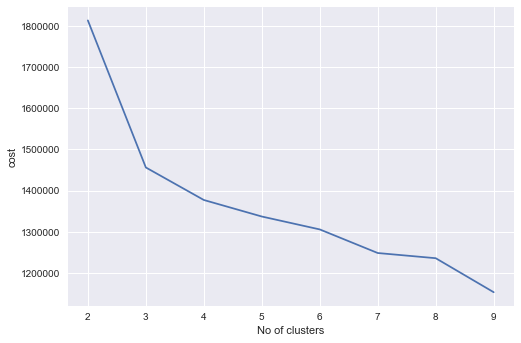

In [23]:
plt.plot(n_clusters, costs)
plt.xlabel('No of clusters')
plt.ylabel('cost')
plt.show()

#### It seems like k=3 is reasonable value for number of clusters. Let's run this and find our four centroids.

In [28]:
km = kmodes.KModes(n_clusters=3, init='Huang', n_init=5)
clusters = km.fit_predict(X_encoded)
km.cost_

1683212.0

In [29]:
np.unique(clusters, return_counts=True)

(array([0, 1, 2], dtype=uint8), array([186700, 186493, 112410], dtype=int64))

In [30]:
print(km.cluster_centroids_)

[[  5  31   7   1  56   4   2   2  10   0]
 [  1  31  20   2 263   4   0   0   0   1]
 [  5  31   0   1 366   4   2   2   0   5]]


In [31]:
centroids = encoder.inverse_transform(pd.DataFrame(km.cluster_centroids_, columns=X_encoded.columns))
centroids.head()

,jurisdiction,company_type,status,service_provider,country_codes,note,valid_until,sourceID,incorporation_month,incorporation_dayofweek
0,BVI,NaN,Defaulted,Mossack Fonseca,CHE,NaN,The Panama Papers data is current through 2015,Panama Papers,11,Friday
1,BAH,NaN,NaN,NaN,NaN,NaN,The Bahamas Leaks data is current through earl...,Bahamas Leaks,01,Monday
2,BVI,NaN,Active,Mossack Fonseca,VGB,NaN,The Panama Papers data is current through 2015,Panama Papers,01,Tuesday
